# Current Plan
1. Create a function to calculate the distance between descriptions, use that function to naively classify new descriptions. probably looks something like a search function.
2. Grab a text classification model of hugging face and fine-tune it on the dataset.

In [1]:
# setup requirements, which aren't loading in the venv for some reason
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Data Preperation

### Cleaning 
The data is already pretty clean as far as non gramatical structures go. Removing all non-alphanumeric characters and lowercasing actually seems to reduce performance a bit on the embedding model, and these characters are allready stripped in the tokenization process for the naive models.

That said, I've i've removed the non-alphanumeric characters and lowercased them in the hopes that it will help generalise. With more thought, including some reasonable punctuation would help the embedding models.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re

with open('data/Datas.csv') as file:
    data = pd.read_csv(file)

data['Description'] = data['Description'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
data['Description'] = data['Description'].apply(lambda x: x.lower())

# Change all Categories other than Food and Entertainment to Other
#data['Category'] = ['Other' if category not in ['Food', 'Entertainment'] else category for category in data['Category']]


### Augmentation/Expansion
My Efforts at Augmenting and Expanding the data weren't very successful. 
There was minor success undersampling the majority classes, but this came at the cost of a usable dataset size.
Advanced techinques, such as LLM sythesis and ADASYN, were not feasible due to time and data constraints.

The unfinished code for the failed augmentations is on the main branch.

#### Splitting
Categories with only 2 or less entries were removed as they caused issues splitting and evaluating the model. \
Uncomment the 2nd last line to reintroduce them to the test set. Note, this will break the lables on the confusion matrix. 

In [3]:
# Split the training set into train, test and val sets
from sklearn.model_selection import train_test_split
# class must have at least 3 samples to be split
tmp = data.groupby('Category').filter(lambda x: len(x) <= 2)
data = data.groupby('Category').filter(lambda x: len(x) > 2)
train, test = train_test_split(data, test_size=0.2, stratify=data['Category'], random_state=42)
#test = pd.concat([test, tmp], axis=0)
train, val = train_test_split(train, test_size=0.3, stratify=train['Category'], random_state=77)

#### Sampling - NOT IN USE

In [4]:
# # Resample the training set
# from imblearn.under_sampling import RandomUnderSampler

# X_train, y_train = train[['Description']], train['Category']
# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# X_train, y_train = undersampler.fit_resample(X_train, y_train)

# # join back because I don't want to refactor the notebook rn
# train = pd.concat([X_train, y_train], axis=1)   
# print(train.shape, val.shape, test.shape)
# # save data
# train.to_csv('data/train.csv', index=False)

## Evaluation tools

In [5]:
from sklearn.metrics import  confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from contextlib import suppress
import matplotlib.pyplot as plt
def evaluate(Y_true, Y_pred, dataset_name="Train"):
    # evaluate using the sklearn functions
    precision = precision_score(Y_true, Y_pred, average='macro') #TP / (TP + FP)
    recall = recall_score(Y_true, Y_pred, average='macro') #TP / (TP + FN)
    f1_macro = f1_score(Y_true, Y_pred, average='macro')
    f1 = f1_score(Y_true, Y_pred, average='weighted')
    accuracy = accuracy_score(Y_true, Y_pred) #(TP + TN) / (TP + FP + FN + TN)
    
    # plot
    print(dataset_name," Precision(macro):", precision)
    print(dataset_name," Recall(macro):", recall)
    print(dataset_name," F1 Score(macro):", f1_macro)
    print(dataset_name," F1 Score(weighted):", f1)
    print(dataset_name," Accuracy:", accuracy)
    
def plot_confusion(Y_true, Y_pred, model, fig_name="confusion.png"):
    confusion = confusion_matrix(Y_true, Y_pred)
    disp = ConfusionMatrixDisplay(confusion, display_labels= model.classes_)
    with suppress(ValueError): # unknown target labels raise an error, but the figure is still produced without labels which is preferable
        disp.plot(xticks_rotation=90)
    plt.savefig('analysis/'+fig_name, bbox_inches='tight')
    plt.show()

## 1. Basic SciKitLearn Models

### Tokenization

In [6]:
# Function to measure distance 
from sklearn.feature_extraction.text import TfidfVectorizer
# have a think about whether the data needs cleaning

tfidf = TfidfVectorizer() # use token_pattern to remove punctuation if needed
tfidf.fit(train['Description']) # val set not included here 

TfidfVectorizer()

### SKLearn Models
Testing the variety of models, SVM and Naive Bayes worked the best on the raw data, while KNN and RF didn't work as well as expected.
All models suffered from the distibution issue in the datset, only predicting the most common classes (food and entertainment).

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training accuracy: 0.6030478955007256
Val  Precision(macro): 0.11147186147186149
Val  Recall(macro): 0.1274202470957035
Val  F1 Score(macro): 0.10250035018910211
Val  F1 Score(weighted): 0.4558903035709458
Val  Accuracy: 0.5087719298245614


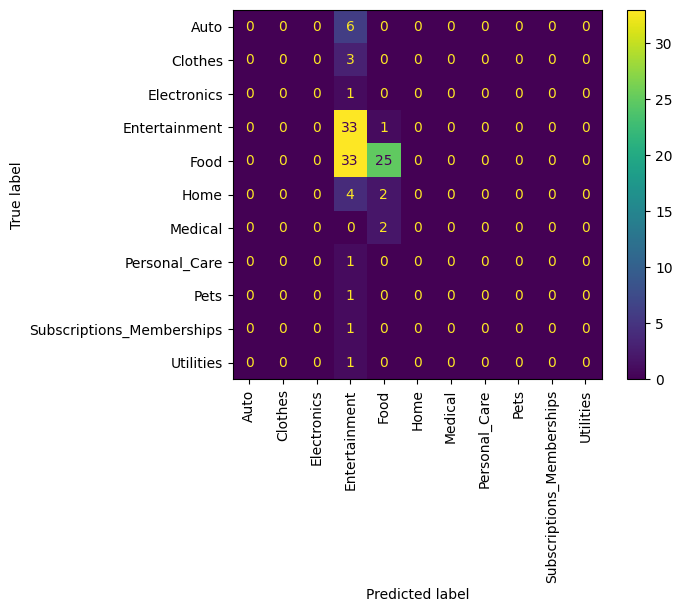

In [7]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# setup KNN
k = int(np.sqrt(train['Category'].count())) # sqrt(n) is a common choice for k
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn.fit(tfidf.transform(train['Description']).toarray(), train['Category'])

# predict
train_accuracy = cross_val_score(knn, tfidf.transform(train['Description']).toarray(), train['Category'], cv=5, scoring='accuracy')
val_hat = knn.predict(tfidf.transform(val['Description']).toarray())

# evaluate
print("training accuracy:", train_accuracy.mean())
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, knn, "confusion_matricies/knn.png")

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training accuracy: 0.6878084179970972
Val  Precision(macro): 0.15221987315010568
Val  Recall(macro): 0.1657754010695187
Val  F1 Score(macro): 0.15534376018246984
Val  F1 Score(weighted): 0.6792271898383953
Val  Accuracy: 0.7543859649122807


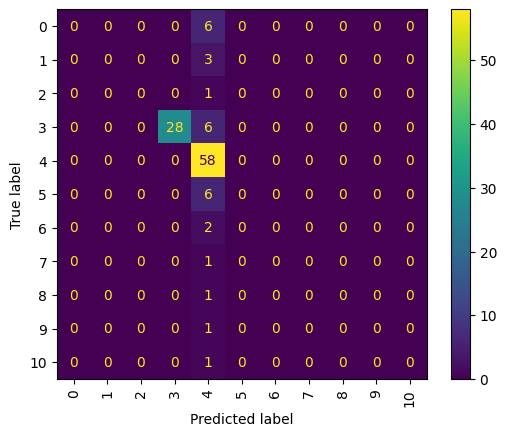

In [8]:
# SVM
from sklearn.svm import SVC

# prepare data labels to be numerical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Category'])
train_Y = le.transform(train['Category'])
val_Y = le.transform(val['Category'])

# setup SVM
svm = SVC(kernel='linear')
svm.fit(tfidf.transform(train['Description']).toarray(), train_Y)

# predict
train_accuracy = cross_val_score(svm, tfidf.transform(train['Description']).toarray(), train['Category'], cv=5, scoring='accuracy')
val_hat = svm.predict(tfidf.transform(val['Description']).toarray())

# evaluate
print("training accuracy:", train_accuracy.mean())
evaluate(val_Y, val_hat, "Val")
plot_confusion(val_Y, val_hat, svm, "confusion_matricies/svm.png")

## 2. HuggingFace Models

### Embedding

In [9]:
# MiniLM encoding; full guide: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
import pandas as pd 
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(train['Description'].values)

assert len(embeddings) == train['Description'].count() 

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### SkLearn Models on Embeddings

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val  Precision(macro): 0.1456382715613186
Val  Recall(macro): 0.1657754010695187
Val  F1 Score(macro): 0.1531121360908595
Val  F1 Score(weighted): 0.6755142083249586
Val  Accuracy: 0.7543859649122807


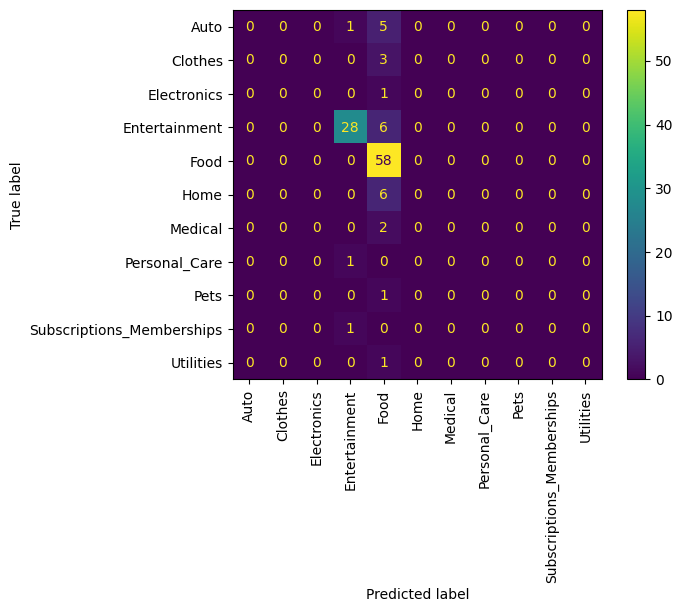

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test  Precision(macro): 0.3354759718396082
Test  Recall(macro): 0.24165120593692022
Test  F1 Score(macro): 0.2588094382560786
Test  F1 Score(weighted): 0.7401095624436587
Test  Accuracy: 0.8


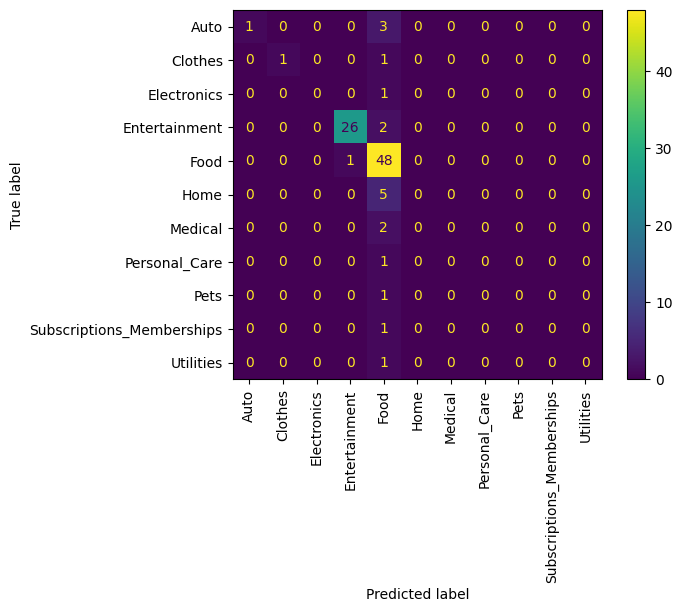

In [10]:
# KNN on embeddings
from sklearn.neighbors import KNeighborsClassifier

# setup KNN
k = int(np.sqrt(train['Category'].count())) # sqrt(n) is a common choice for k
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn.fit(embeddings, train['Category']) # should still have the same indicies

# predict
train_y_hat = knn.predict(model.encode(train['Description'].values))
val_hat = knn.predict(model.encode(val['Description'].values))
test_hat = knn.predict(model.encode(test['Description'].values))

# evaluate
#evaluate(train['Category'], train_hat, "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, knn, "confusion_matricies/knn_embeddings.png")
evaluate(test['Category'], test_hat, "Test")
plot_confusion(test['Category'], test_hat, knn, "confusion_matricies/knn_embeddings_test.png")

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val  Precision(macro): 0.23901351174078445
Val  Recall(macro): 0.19005470526768703
Val  F1 Score(macro): 0.18585858585858583
Val  F1 Score(weighted): 0.7173489278752436
Val  Accuracy: 0.7894736842105263


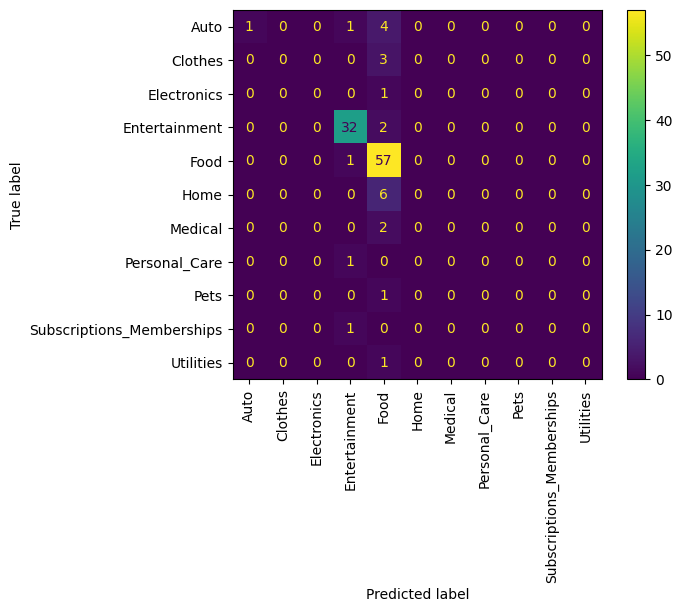

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test  Precision(macro): 0.2912568306010929
Test  Recall(macro): 0.24174397031539885
Test  F1 Score(macro): 0.2520403316641561
Test  F1 Score(weighted): 0.7684468223851164
Test  Accuracy: 0.8210526315789474


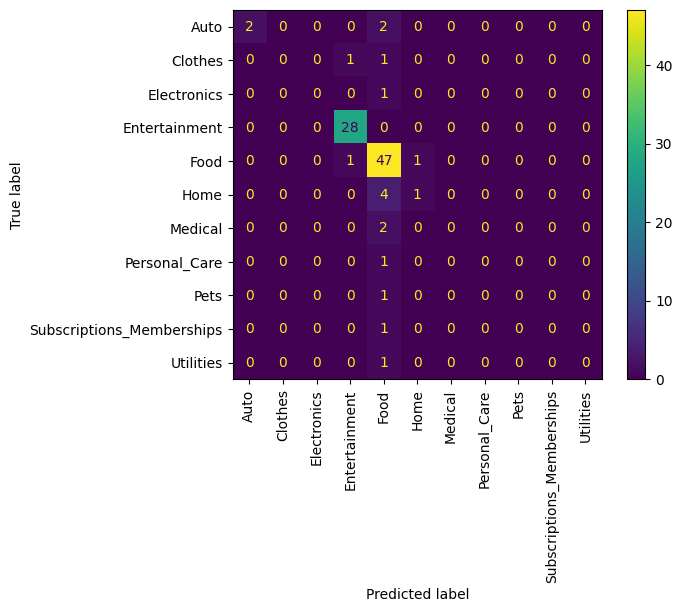

In [11]:
# SVM on embeddings
from sklearn.svm import SVC

# setup SVM
svm = SVC(kernel='linear')
svm.fit(embeddings, train['Category'])

# predict
val_embeddings = model.encode(val['Description'].values)
train_hat = svm.predict(embeddings)
val_hat = svm.predict(val_embeddings)
test_hat = svm.predict(model.encode(test['Description'].values))

# Evaluate
#evaluate(train['Category'], train_hat, "Test")
evaluate(val['Category'], val_hat, "Val")
plot_confusion(val['Category'], val_hat, knn, "confusion_matricies/svm_embeddings.png")
evaluate(test['Category'], test_hat, "Test")
plot_confusion(test['Category'], test_hat, knn, "confusion_matricies/svm_embeddings_test.png")

/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/james/projects/categoryPrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val  Precision(macro): 0.43003155862105896
Val  Recall(macro): 0.47886442510098426
Val  F1 Score(macro): 0.42821507445163354
Val  F1 Score(weighted): 0.808160552897395
Val  Accuracy: 0.8245614035087719


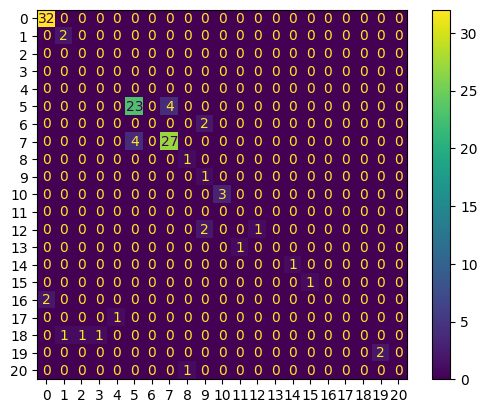

In [12]:
# SVM on embeddings subcategories
from sklearn.svm import SVC

# prepare data labels to be numerical
from sklearn.preprocessing import LabelEncoder
cat_le = LabelEncoder()
cat_le.fit(train['Category'])
train_cat = cat_le.transform(train['Category'])
val_cat = cat_le.transform(val['Category'])

subcat_le = LabelEncoder()
# unique values of subcategories
subcats = np.append(train['Sub_Category'].unique(), "Unknown")
subcat_le.fit(subcats)
train_Y = subcat_le.transform(train['Sub_Category'])
val['Sub_Category'] = [subcat if subcat in subcats else "Unknown" for subcat in val['Sub_Category']]
val_Y = subcat_le.transform(val['Sub_Category'])

#concat train_Y to final column in embeddings
#embeddings = np.concatenate((embeddings, train_cat), axis=1)
embeddings = np.column_stack((embeddings, train_cat))
val_embeddings = model.encode(val['Description'].values)
val_embeddings = np.column_stack((val_embeddings, val_cat))

# setup
n_svm = SVC(kernel='linear')
n_svm.fit(embeddings, train_Y)

# predict
train_y_hat = n_svm.predict(embeddings)
val_Y_hat = n_svm.predict(val_embeddings)

# Evaluate
#evaluate(train['Category'], train_hat, "Test")
evaluate(val_Y, val_Y_hat, "Val")
plot_confusion(val_Y, val_Y_hat, n_svm, "confusion_matricies/svm_embeddings_subcategories.png")